In [1]:
%load_ext jupyter_black
import os
import re
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(1, "/home/jupyter/ee_segmentation/models/models")
from Models import model_Selection

sys.path.insert(1, "/home/jupyter/ee_segmentation/notebooks/ML")
from Data_Set_and_Loader import get_data2
from utilss import initiate_dirs, evaluate_model

# Visualize the result of the best performing model

- **Farseg**:
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet50_Image_size:512"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet50_Image_size:512"
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet101_Image_size:512"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet101_Image_size:512"
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet50_Image_size:1024"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet50_Image_size:1024"
- **U-Net**:
    - "U-Net_Bands['B6', 'B7', 'B2']_backbone-1_Image_size512_trained"
    - "U-Net_Bands['B2', 'B3', 'B4']_backbone-1_Image_size512_trained"
    - "U-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"
    - "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:512"
    - "U-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:1024"
    - "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:1024"
- **SegNet**:
    - "Seg-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"
    - "Seg-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:512"

In [3]:
model = "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet50_Image_size:1024"
# model = "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:512"
# model = "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:1024"
model_name = model
bands_selection = [band for band in re.findall("'(\S+)'", model)]
batch_size = 1
img_size = int(re.findall(":(\d+)", model)[0])
initiate_dirs(model_name)
trainloader, valloader, testloader = get_data2(
    model_name=model_name,
    bands_selection=bands_selection,
    batch_size=batch_size,
    img_size=img_size,
)
trainloader.dataset.eval()
testloader.dataset.eval()

Folder for this model is already created


In [4]:
def vis_best_model_output(model, dataloader):
    best_epoch = best_model(model)
    b_model = load_model(model, best_epoch)
    display_result(dataloader, b_model)

In [5]:
# model = "U-Net_Bands:['B2']_Image_size:128"
# vis_best_model_output(model, valloader)

In [6]:
os.path.abspath(os.curdir)

'/home/jupyter/ee_segmentation/notebooks/post Process'

In [7]:
def best_model(model):
    cur_dir = os.path.abspath(os.curdir)
    folder_dir = os.path.join(
        os.path.curdir, "..", "..", "models", "trainned models", model
    )
    os.chdir(folder_dir)
    r = re.compile(".+metrics\.csv")
    metrics_file = list(filter(r.match, os.listdir()))[0]
    metrics = pd.read_csv(metrics_file)
    best_epoch = metrics[metrics["Validation IOU"] == metrics["Validation IOU"].max()][
        "Epoch"
    ]
    os.chdir(cur_dir)
    return best_epoch.iloc[0]

In [8]:
best_epoch = best_model(model_name)
best_epoch

215

In [9]:
curdir = "/home/jupyter/ee_segmentation/notebooks/post Process"
os.chdir(curdir)

In [10]:
def load_model(model, model_epoch):
    cur_dir = os.path.abspath(os.curdir)
    folder_dir = os.path.join(
        os.path.curdir, "..", "..", "models", "trainned models", model
    )
    os.chdir(folder_dir)
    r = re.compile(f".+epoch{model_epoch}.pt")
    model_file = list(filter(r.match, os.listdir()))[0]

    model_type = re.findall("(\S+)_Bands:", model_file)[0]
    bands = [band for band in re.findall("'(\S+)'", model_file)]
    backbone = re.findall("_backbone:(\S+)_Ima", model_file)[0]

    network = model_Selection(model_type, bands, backbone_network=backbone)
    network.load_state_dict(torch.load(model_file))
    os.chdir(cur_dir)
    return network

In [11]:
net = load_model(model, best_epoch)

FarSeg


In [12]:
def IOU(mask, pred):
    pred = pred > 0.5
    intersection_total = (pred * mask).sum()
    union_total = (pred + mask).sum()

    iou = intersection_total / union_total
    return iou

In [13]:
def normilize_bands(tensor, min_val=0.0, max_val=0.3):
    for i in range(tensor.shape[0]):
        tensor[i] = (tensor[i] - tensor[i].min()) / (tensor[i].max() - tensor[i].min())
        tensor[i] = (tensor[i] - min_val) / (max_val - min_val)
    return tensor

In [14]:
def display_result(dataloader, model):
    model.eval()
    for data in dataloader:
        imgs, masks = data
        preds = model(imgs)
        for i in range(imgs.shape[0]):
            iou = IOU(masks[i], preds[i])
            fig, ax = plt.subplots(1, 3)
            if imgs[i].shape[0] == 3:
                rgb_norm = normilize_bands(imgs[i])
                # rgb_norm = (imgs[i] - np.min(imgs[i].numpy())) / (
                #     np.max(imgs[i].numpy()) - np.min(imgs[i].numpy())
                # )
                ax[0].imshow(rgb_norm.permute(1, 2, 0))
            else:
                ax[0].imshow(imgs[i].permute(1, 2, 0))
            ax[1].imshow(masks[i].permute(1, 2, 0))
            ax[2].imshow(preds[i].permute(1, 2, 0).detach().numpy())
            plt.show()
            print(f"IOU:{iou:.2%}")
            print(f"prediction max: {preds[i].max()}, prediction min: {preds[i].min()}")

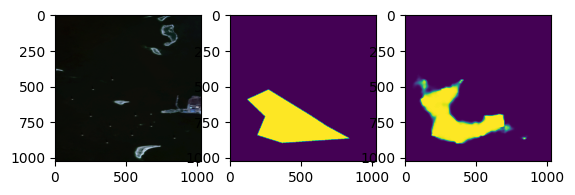

IOU:52.75%
prediction max: 1.0, prediction min: 7.295426068809618e-11


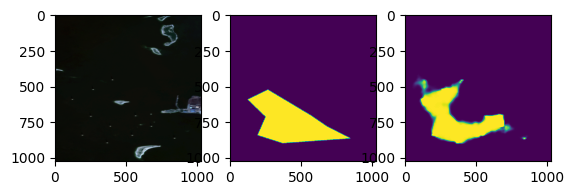

IOU:52.08%
prediction max: 1.0, prediction min: 7.295426068809618e-11


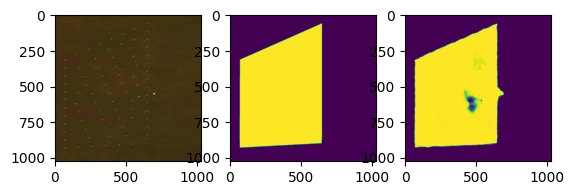

IOU:97.51%
prediction max: 1.0, prediction min: 6.868048491037726e-11


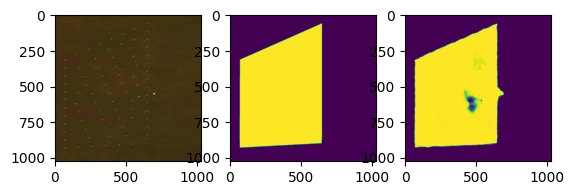

IOU:97.51%
prediction max: 1.0, prediction min: 6.868048491037726e-11


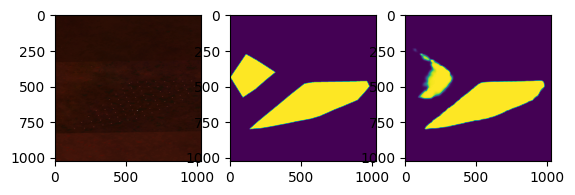

IOU:75.09%
prediction max: 1.0, prediction min: 4.336933590032288e-10


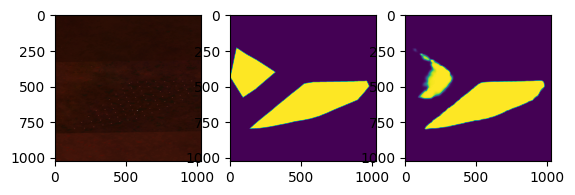

IOU:72.14%
prediction max: 1.0, prediction min: 4.336933590032288e-10


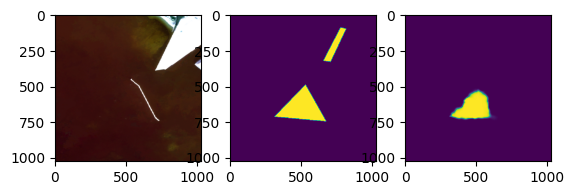

IOU:59.15%
prediction max: 0.9999805688858032, prediction min: 2.057930215126902e-11


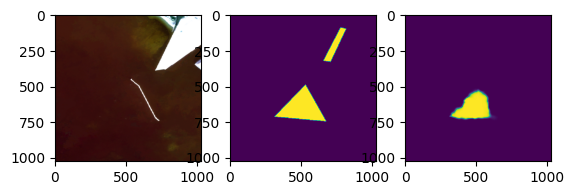

IOU:59.15%
prediction max: 0.9999805688858032, prediction min: 2.057930215126902e-11


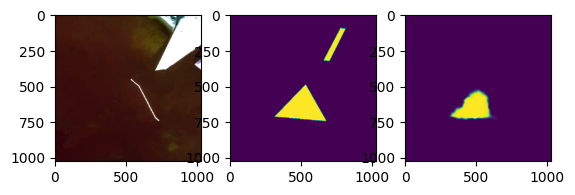

IOU:61.07%
prediction max: 0.9999805688858032, prediction min: 2.057930215126902e-11


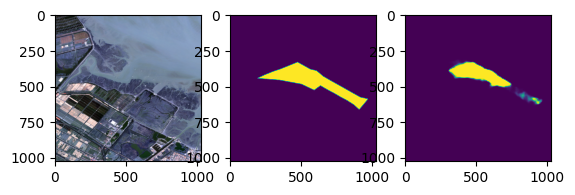

IOU:49.66%
prediction max: 1.0, prediction min: 1.12476261637795e-09


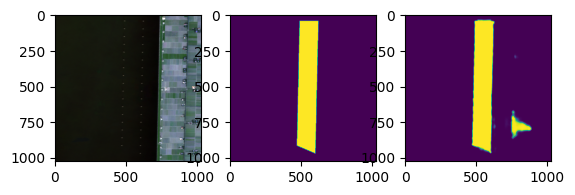

IOU:88.47%
prediction max: 1.0, prediction min: 1.6705650196513488e-09


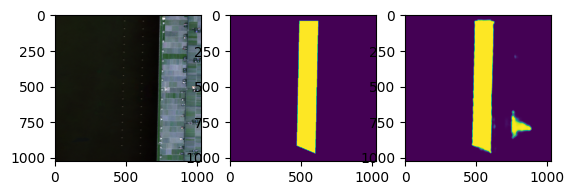

IOU:87.32%
prediction max: 1.0, prediction min: 1.6705650196513488e-09


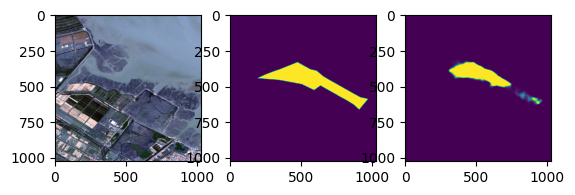

IOU:49.73%
prediction max: 1.0, prediction min: 1.12476261637795e-09


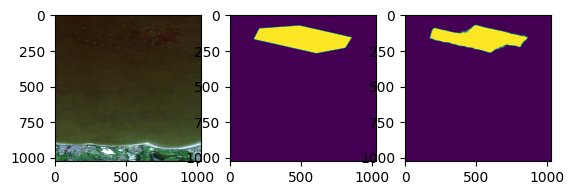

IOU:81.34%
prediction max: 1.0, prediction min: 1.2058559706318306e-10


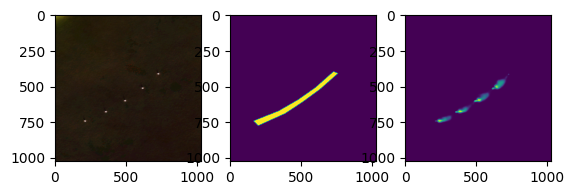

IOU:12.32%
prediction max: 0.9514636993408203, prediction min: 5.717001871907712e-11


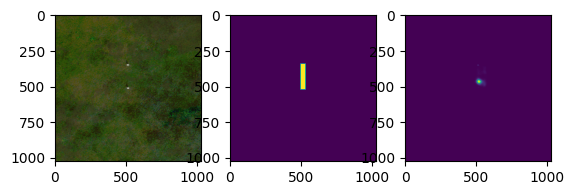

IOU:1.83%
prediction max: 0.5685681700706482, prediction min: 4.4330344950438416e-11


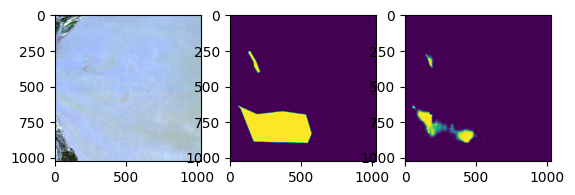

IOU:23.77%
prediction max: 0.9999998807907104, prediction min: 3.111226476448792e-08


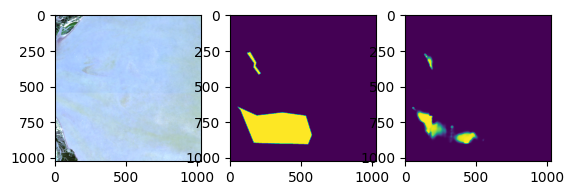

IOU:24.42%
prediction max: 1.0, prediction min: 4.740218884080605e-08


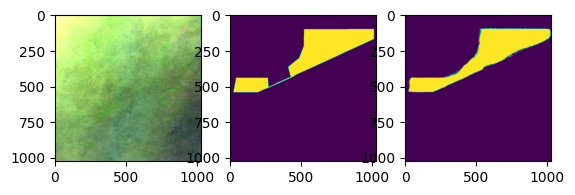

IOU:87.34%
prediction max: 1.0, prediction min: 4.799526661519726e-12


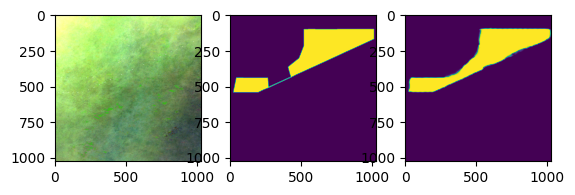

IOU:87.54%
prediction max: 1.0, prediction min: 4.799526661519726e-12


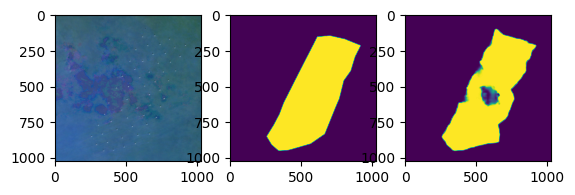

IOU:89.69%
prediction max: 1.0, prediction min: 2.276070998341595e-11


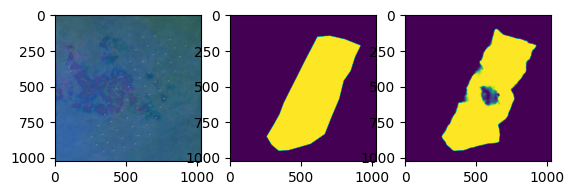

IOU:89.70%
prediction max: 1.0, prediction min: 2.276070998341595e-11


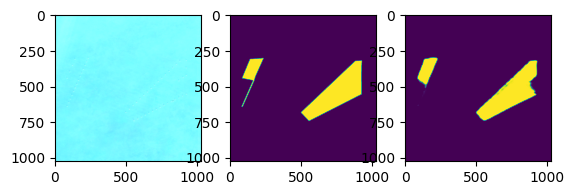

IOU:89.79%
prediction max: 1.0, prediction min: 1.3332336103177855e-11


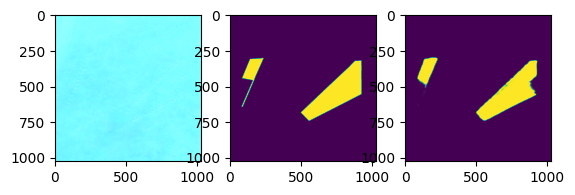

IOU:89.76%
prediction max: 1.0, prediction min: 1.3332336103177855e-11


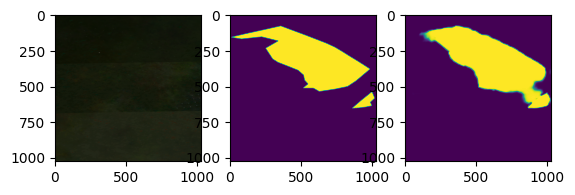

IOU:79.80%
prediction max: 1.0, prediction min: 2.357684603104815e-10


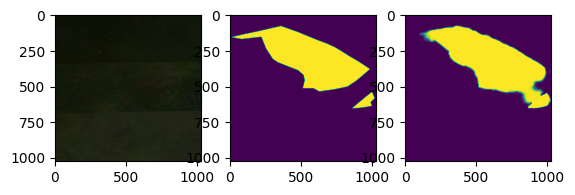

IOU:81.86%
prediction max: 1.0, prediction min: 2.357684603104815e-10


In [15]:
display_result(testloader, net)

# Visualize the metrics

- **Farseg**:
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet50_Image_size:512"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet50_Image_size:512"
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet101_Image_size:512"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet101_Image_size:512"
    - "FarSeg_Bands:['B4', 'B2', 'B7']_backbone:resnet50_Image_size:1024"
    - "FarSeg_Bands:['B2', 'B3', 'B4']_backbone:resnet50_Image_size:1024"
- **U-Net**:
    - "U-Net_Bands['B6', 'B7', 'B2']_backbone-1_Image_size512_trained"
    - "U-Net_Bands['B2', 'B3', 'B4']_backbone-1_Image_size512_trained"
    - "U-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"
    - "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:512"
    - "U-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:1024"
    - "U-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:1024"
- **SegNet**:
    - "Seg-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"
    - "Seg-Net_Bands:['B2', 'B3', 'B4']_backbone:-1_Image_size:512"

In [89]:
model = "Seg-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"

In [90]:
model_name = model
bands_selection = [band for band in re.findall("'(\S+)'", model)]
batch_size = 1
img_size = int(re.findall("\d{3,4}", model)[0])
# img_size = int(re.findall(":(\d+)", model)[0])

In [91]:
initiate_dirs(model_name)
trainloader, valloader, testloader = get_data2(
    model_name=model_name,
    bands_selection=bands_selection,
    batch_size=batch_size,
    img_size=img_size,
)
trainloader.dataset.eval()
testloader.dataset.eval()

Folder for this model is already created


In [92]:
best_epoch = best_model(model)
best_epoch

499

In [93]:
net = load_model(model, best_epoch)

Seg-Net


## Loss

In [94]:
def print_metrics(model):
    model_name = re.findall("(\S+)_Bands", model)[0]
    # backbone = re.findall("backbone:(\S+)_Im", model)[0]
    backbone = re.findall("backbone(\S+)_Im", model)[0]
    bands = re.findall("'(.{2})'", model)
    cur_dir = os.path.abspath(os.curdir)
    folder_dir = os.path.join(
        os.path.curdir, "..", "..", "models", "trainned models", model
    )
    os.chdir(folder_dir)
    r = re.compile(".+metrics\.csv")
    metrics_file = list(filter(r.match, os.listdir()))[0]
    metrics = pd.read_csv(metrics_file)
    fig, ax1 = plt.subplots(figsize=(15, 5))
    for metric in metrics.keys()[2:]:
        ax1.plot(
            metrics["Epoch"],
            metrics[metric] * 100,
            label=metric,
        )
    r = re.compile(".+losses\.csv")
    loss_file = list(filter(r.match, os.listdir()))[0]
    loss = pd.read_csv(loss_file, header=None)
    ax2 = ax1.twinx()
    ax2.plot(loss, label="Loss", c="pink")
    ax1.set_ylabel("IOU and Accuracy (%)")
    ax2.set_ylabel("Loss")
    ax1.legend(loc=1, bbox_to_anchor=(1, 0.7))
    ax2.legend(loc=2)
    if backbone == "-1":
        ax1.set_title(
            f"Loss and metrics for {model_name} Bands: " + ", ".join(b for b in bands)
        )
    else:
        ax1.set_title(
            f"Loss and metrics for {model_name} backbone {backbone} Bands: "
            + ", ".join(b for b in bands)
        )
    plt.show()
    fig.savefig(
        f"Loss and metrics for {model_name} Bands:"
        + ", ".join(b for b in bands)
        + ".png"
    )
    os.chdir(cur_dir)
    # fig.savefig("Loss and metrics for U-Net Bands: B2, B3, B4.png")

In [95]:
curdir = "/home/jupyter/ee_segmentation/notebooks/post Process"
os.chdir(curdir)

In [96]:
model

"Seg-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"

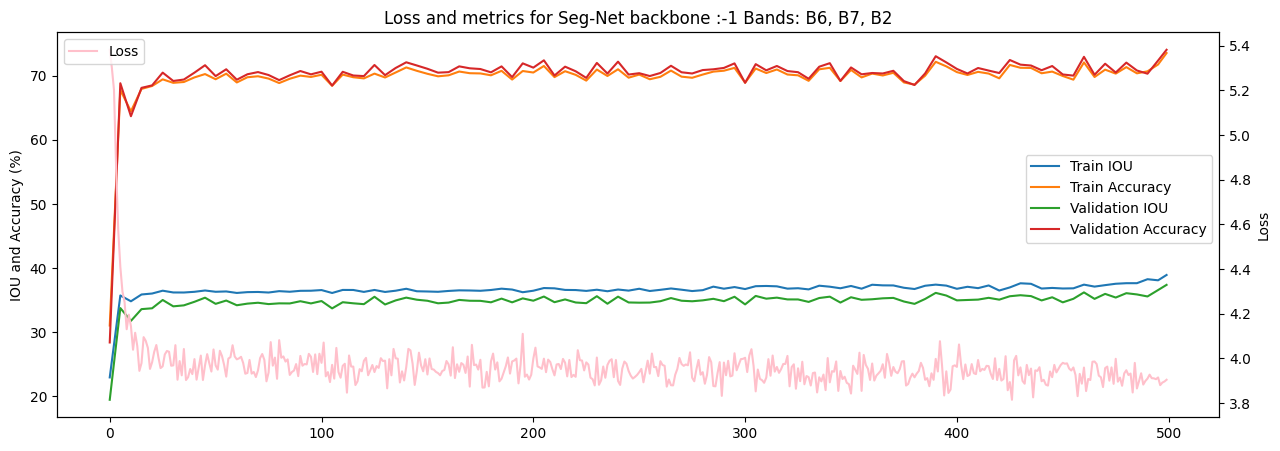

In [97]:
print_metrics(model)

# Evaluate on the test set

## Quantitative

In [98]:
testloader.dataset.eval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [99]:
mIOU, acc = evaluate_model(net, testloader, device)

In [100]:
print(f"The IOU for the model is {mIOU:.2%} the accuracy is {acc:.2%}")

The IOU for the model is 21.70% the accuracy is 67.22%


## Qualitative

In [101]:
model

"Seg-Net_Bands:['B6', 'B7', 'B2']_backbone:-1_Image_size:512"

In [102]:
path = "/home/jupyter/ee_segmentation/notebooks/post Process"
os.chdir(path)

In [103]:
def save_image(dataloader, model, folder):
    image_list = [2, 6, 10, 13, 14, 23]
    a = 0
    model.eval()
    cur_path = os.path.abspath(os.curdir)
    model_file_path = os.path.join(
        os.curdir, "..", "..", "models", "trainned models", folder
    )
    for data in dataloader:
        imgs, masks = data
        preds = model(imgs)
        print(preds.shape, preds.min(), preds.max())
        preds = preds > 0.5
        print(preds.shape, preds.min(), preds.max())
        for i in range(imgs.shape[0]):
            iou = IOU(masks[i], preds[i])
            fig, ax = plt.subplots(1, 3)
            print(imgs[i].shape)
            if imgs[i].shape[0] == 3:
                rgb_norm = normilize_bands(imgs[i])
                # rgb_norm = (imgs[i] - np.min(imgs[i].numpy())) / (
                #     np.max(imgs[i].numpy()) - np.min(imgs[i].numpy())
                # )
                ax[0].imshow(rgb_norm.permute(1, 2, 0))
            else:
                ax[0].imshow(imgs[i].permute(1, 2, 0))
            ax[1].imshow(masks[i].permute(1, 2, 0))
            ax[2].imshow(preds[i].permute(1, 2, 0).detach().numpy())
            ax[0].set_title("Image")
            ax[0].axis("off")
            ax[1].set_title("Ground truth")
            ax[1].axis("off")
            ax[2].set_title("Prediction")
            ax[2].axis("off")
            fig.suptitle(f"IOU: {iou:.2%}", x=0.8, y=0.3)
            plt.show()
            if image_list.count(a) > 0:
                os.chdir(model_file_path)
                fig.savefig(f"Bundle{a}_{folder}.png")
                fig1, ax1 = plt.subplots()
                ax1.imshow(rgb_norm.permute(1, 2, 0))
                ax1.axis("off")
                fig1.savefig(f"image{a}_{folder}.png")
                fig2, ax2 = plt.subplots()
                ax2.imshow(masks[i].permute(1, 2, 0))
                ax2.axis("off")
                fig2.savefig(f"mask{a}_{folder}.png")
                fig3, ax3 = plt.subplots()
                ax3.imshow(preds[i].permute(1, 2, 0).detach().numpy())
                ax3.axis("off")
                fig3.savefig(f"prediction{a}_{folder}.png")
                os.chdir(cur_path)
            print(a)
            a += 1
            print(f"IOU:{iou:.2%}")
            print(f"prediction max: {preds[i].max()}, prediction min: {preds[i].min()}")

In [104]:
os.path.abspath(os.curdir)

'/home/jupyter/ee_segmentation/notebooks/post Process'

torch.Size([1, 1, 512, 512]) tensor(2.4878e-19, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


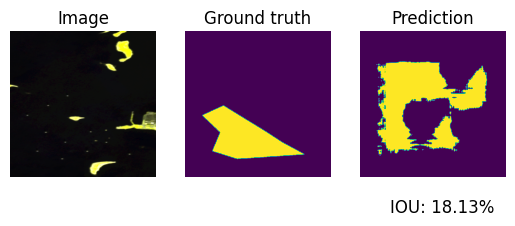

0
IOU:18.13%
prediction max: True, prediction min: False
torch.Size([1, 1, 512, 512]) tensor(2.4878e-19, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)


torch.Size([3, 512, 512])


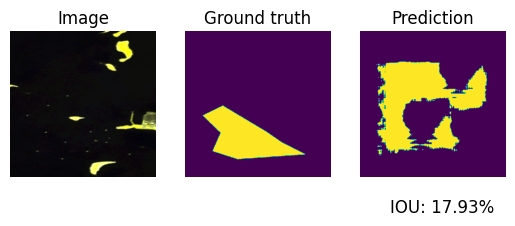

1
IOU:17.93%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(4.3513e-14, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


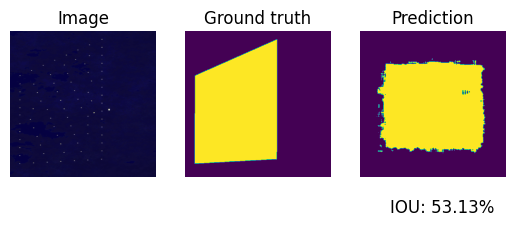

2
IOU:53.13%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(4.3513e-14, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


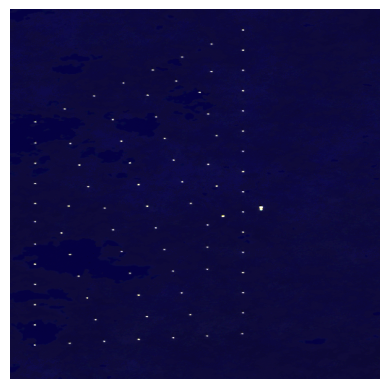

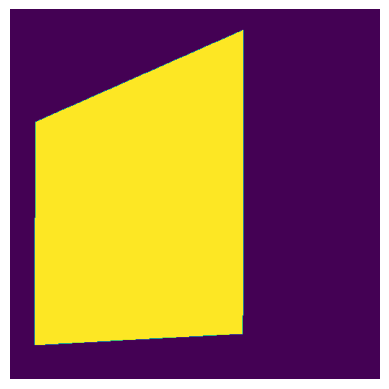

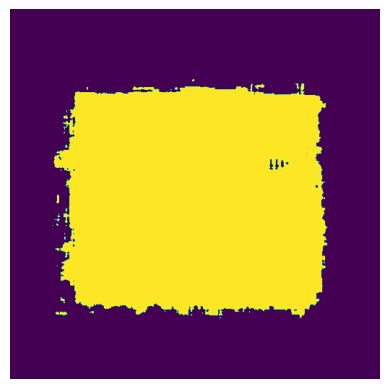

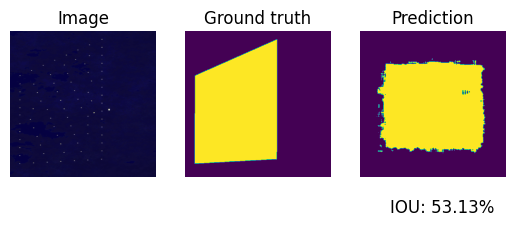

3
IOU:53.13%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(4.2048e-21, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


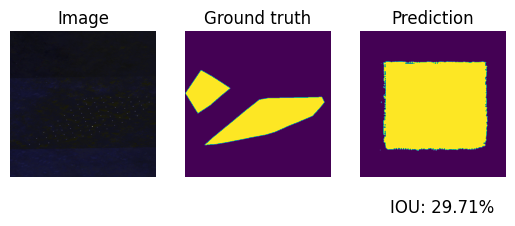

4
IOU:29.71%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(4.2048e-21, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


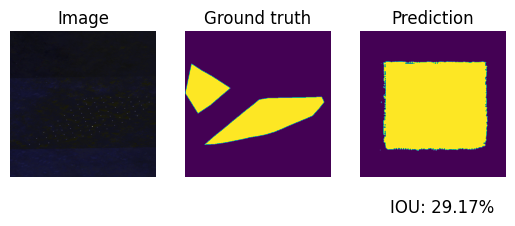

5
IOU:29.17%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(2.8253e-33, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


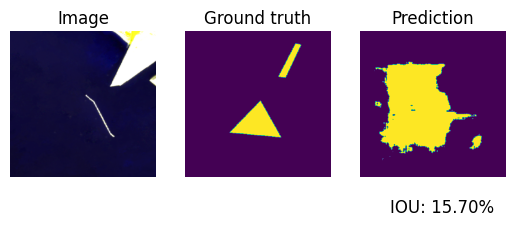

6
IOU:15.70%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(2.8253e-33, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


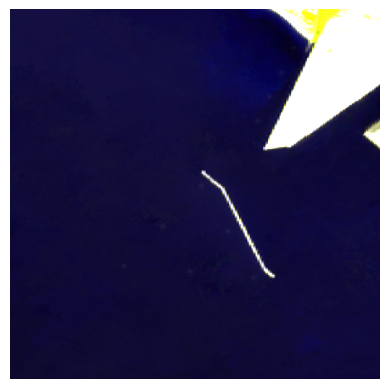

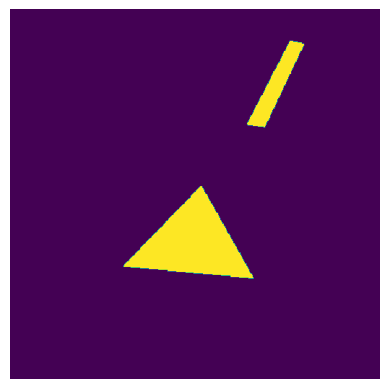

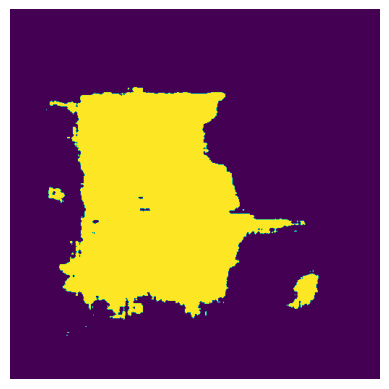

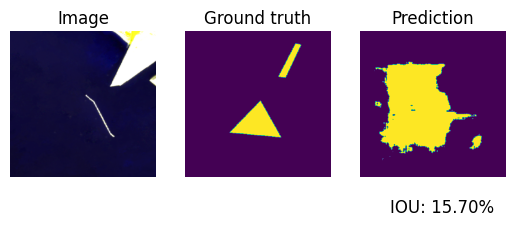

7
IOU:15.70%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(2.8253e-33, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


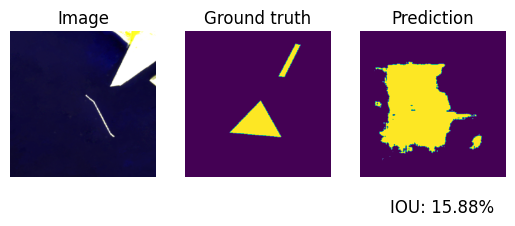

8
IOU:15.88%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(1.1770e-25, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


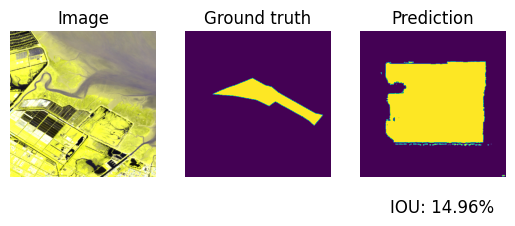

9
IOU:14.96%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.5902e-32, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


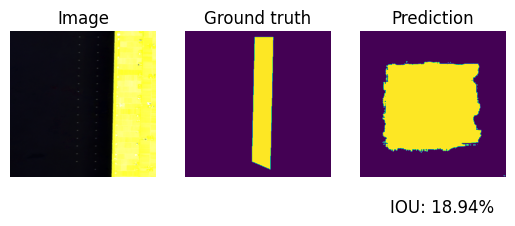

10
IOU:18.94%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.5902e-32, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


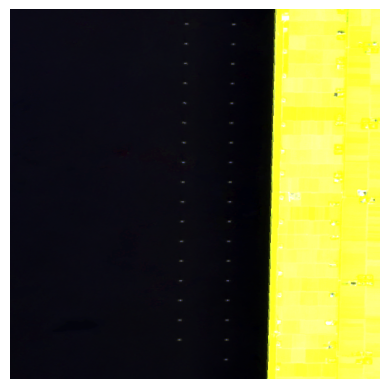

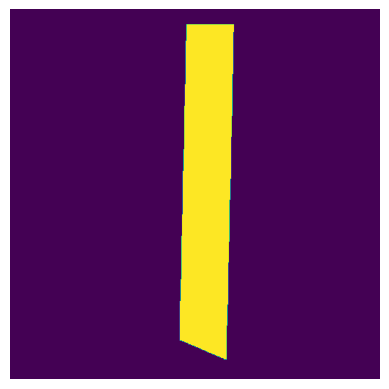

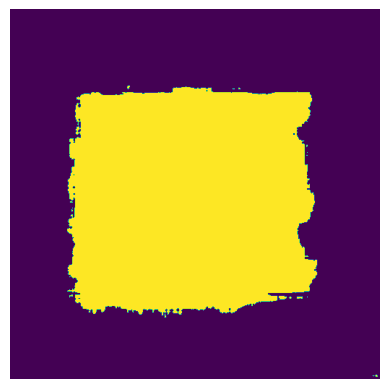

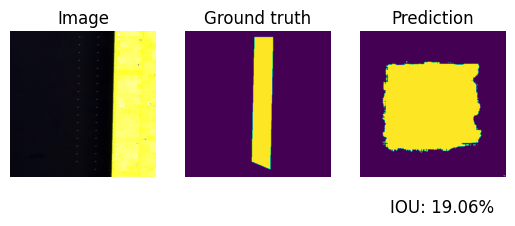

11
IOU:19.06%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(1.1770e-25, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


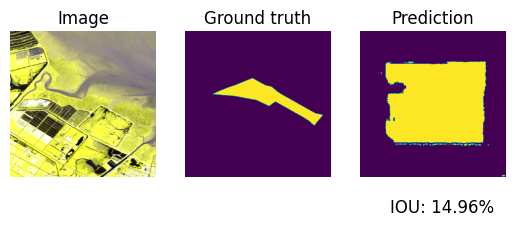

12
IOU:14.96%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(8.9343e-13, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


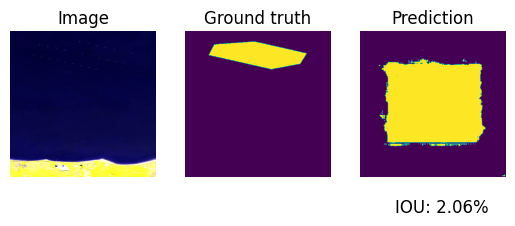

13
IOU:2.06%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(2.0838e-19, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


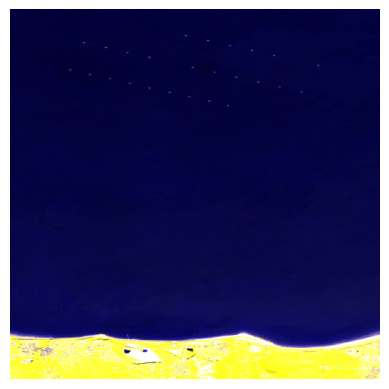

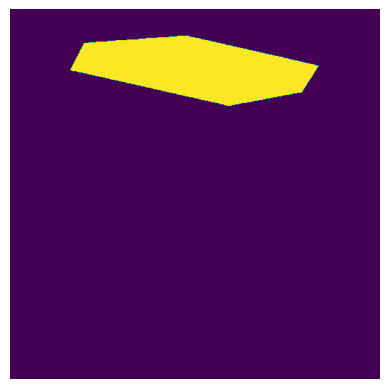

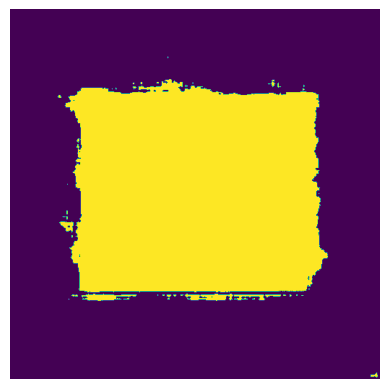

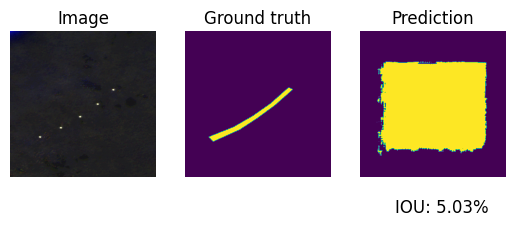

14
IOU:5.03%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.8370e-11, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


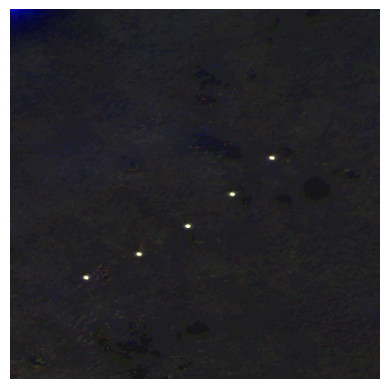

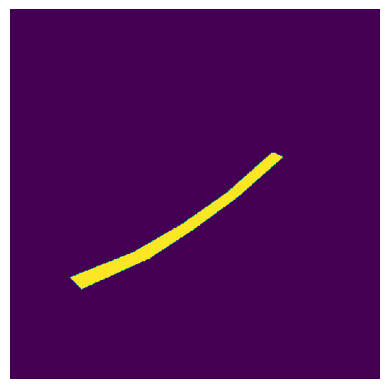

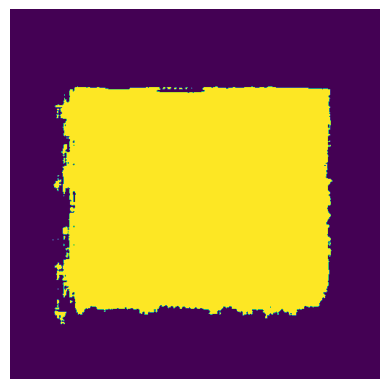

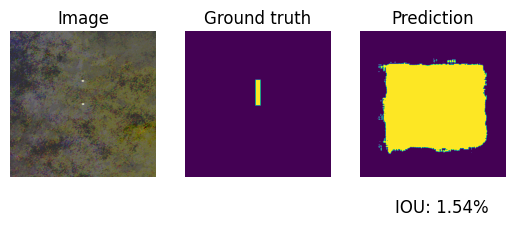

15
IOU:1.54%
prediction max: True, prediction min: False
torch.Size([1, 1, 512, 512]) tensor(3.7811e-27, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)


torch.Size([3, 512, 512])


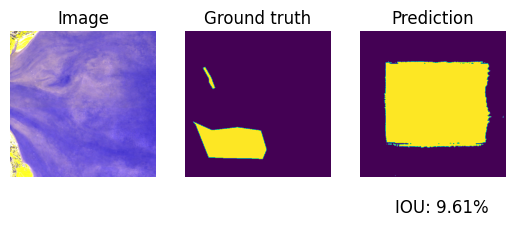

16
IOU:9.61%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(1.2312e-25, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


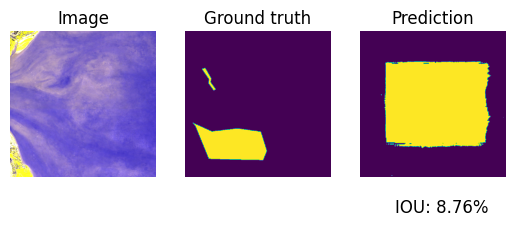

17
IOU:8.76%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.3877e-13, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


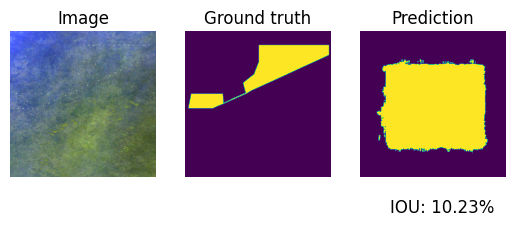

18
IOU:10.23%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.3877e-13, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


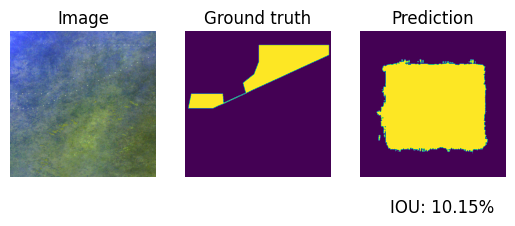

19
IOU:10.15%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.7341e-19, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


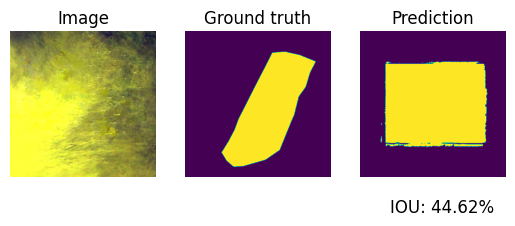

20
IOU:44.62%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.7341e-19, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


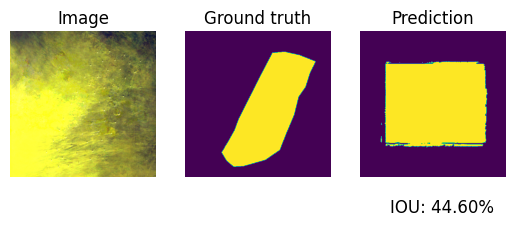

21
IOU:44.60%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.4211e-22, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


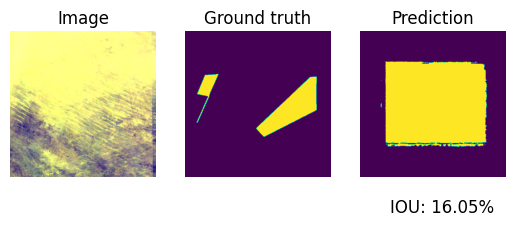

22
IOU:16.05%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(5.4211e-22, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


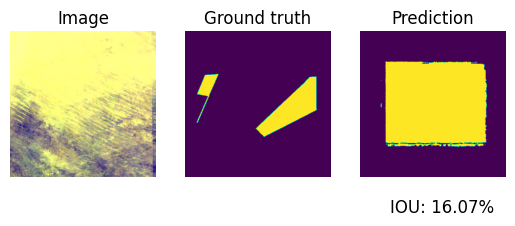

23
IOU:16.07%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(8.8651e-18, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


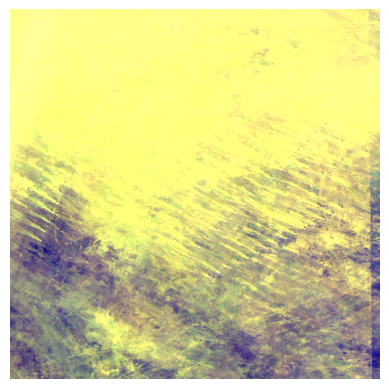

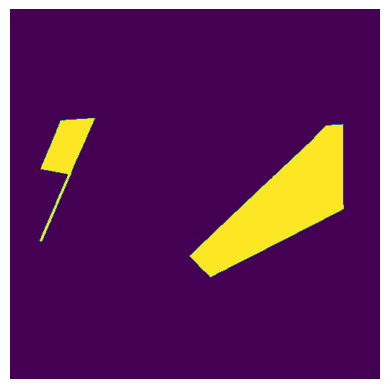

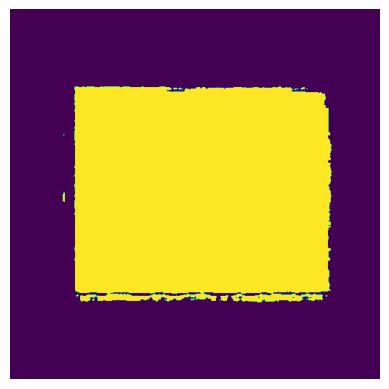

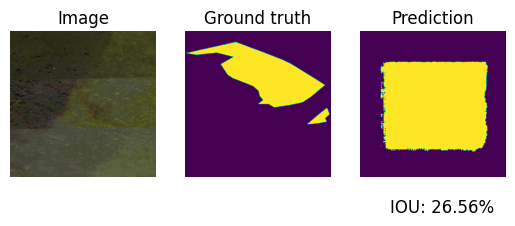

24
IOU:26.56%
prediction max: True, prediction min: False


torch.Size([1, 1, 512, 512]) tensor(8.8651e-18, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)
torch.Size([1, 1, 512, 512]) tensor(False) tensor(True)
torch.Size([3, 512, 512])


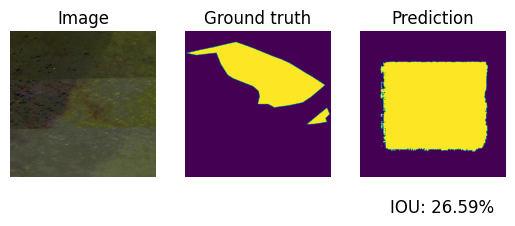

25
IOU:26.59%
prediction max: True, prediction min: False


In [105]:
save_image(testloader, net, model)